# ML Task 2.3 - Complex ML models - Random Forests - Part 2

## Table of Contents

#### 01. Import libraries and datasets

#### 02. Data preprocessing

#### 03. Split data into training and testing sets

#### 04. Train Random Forests model and predict

#### 05. Plot two decision trees

#### 06. Calculate station-feature importances, plot Top 10

#### 07. Aggregate to station-level importances, plot these

#### 08. Interpretation of interim results

### 01. Import libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.metrics import accuracy_score

In [3]:
# Create path to dataset location
path = r'C:\Users\dirk8\CareerFoundry\07-2025 Machine Learning With Python\Datasets\Unsupervised'

In [9]:
# Import unscaled weather dataset and Pleasant Weather answers dataset, respectively, without the index column
df_unscaled = pd.read_excel(os.path.join(path, 'cleaned_weather_unscaled_2001_2010_no_date.xlsx'), index_col=None)
pleas_ans = pd.read_csv(os.path.join(path, 'pleasant_ans_2001_2010_no_date.csv'), index_col=None)

### 02. Data preprocessing

#### Comment: The unscaled weather dataset uploaded here was already preprocessed in the Excel file as follows: (i) 'DATE' and 'MONTH' columns were dropped as we only need numerical data for the Random Forests model inputs -- prior to dropping the columns, the period 2001-01-01 to 2010-12-31 (10 years) was selected for the first part of the Random Forests exercise; (ii) Roma, Gdansk & Tours weather stations and all their associated weather features (columns) were dropped; (iii) the 'snow_depth' (only 6 weather stations had this feature) and 'wind_speed' (only 9 weather stations had this feature) weather features (columns) were dropped from ALL weather stations, to ensure that we have an identical (and in the exact same sequence) set of nine (9) weather features per weather station; (iv) 'cloud_cover' weather feature was only missing for Kassel weather station, so Dusseldorf (229 km away, similar latitude) weather station's data series for that feature was copied to Kassel; (v) 'pressure' weather feature was only missing for MunchenB weather station, so Basel (which has a closer latitude to Munich than Sonnblick does, and a 260-metre elevation versus Sonnblick's 3,100 metres) weather station's data series for that feature was copied to MunchenB; and (vi) 'humidity' weather feature was only missing for Stockholm weather station, so Oslo (similar latitude, also a coastal city) weather station's data series for that feature was copied to Stockholm.

#### Meanwhile, in the Pleasant weather answers dataset uploaded here, the 'DATE' column was dropped as it is not needed for the Random Forests model runs in this exercise; however, prior to dropping that column the period 2001-01-01 to 2010-12-31 (10 years) was selected for the first part of the Random Forests exercise.

#### Data accuracy problem workaround: Kassel and Valentia weather stations, which Task 2.3 requires be included in the weather dataset for Random Forests modeling-based binary classification prediction, unfortunately have inaccurate data (frozen, pardon the pun, at fixed constant values) for most or all of their weather variables over the final 9-12.9 years of the dataset, representing ~ 14.3% (Kassel, 9 years of bad data) and ~ 18.7-19.8% (Valentia, 11.8-12.9 years of bad data) of their 62+ year temporal range of time series data.  Workaround: the first part of Task 2.3 requires model run(s) on a subset decade of data, thus 2001-2010 was the decade selected for model input, to avoid the 9-12+ years of bad data present later at Kassel and Valentia weather stations, which together represent >13% of the 15 weather stations (by station count and proportion of weather data values).

In [11]:
# Check dimensions
print(df_unscaled.shape)
print(pleas_ans.shape)

(3652, 135)
(3652, 15)


In [13]:
# Check a few lines of the weather dataset
df_unscaled.head(2)

BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  BASEL_global_radiation  \
0                  7            0.68          1.0086                    0.16   
1                  8            0.81          1.0049                    0.18   

   BASEL_precipitation  BASEL_sunshine  BASEL_temp_mean  BASEL_temp_min  \
0                 1.22             0.0              0.8            -1.3   
1                 1.01             0.0              6.6             3.5   

   BASEL_temp_max  BELGRADE_cloud_cover  ...  STOCKHOLM_temp_max  \
0             4.4                     4  ...                -0.6   
1             9.2                     2  ...                 2.0   

   VALENTIA_cloud_cover  VALENTIA_humidity  VALENTIA_pressure  \
0                     7                0.9             0.9702   
1                     4                0.8             0.9842   

   VALENTIA_global_radiation  VALENTIA_precipitation  VALENTIA_sunshine  \
0                       0.14                    1.09                0.0   
1                       0.24                    0.14                1.7   

   VALENTIA_temp_mean  VALENTIA_temp_min  VALENTIA_temp_max  
0                 8.9                7.3               10.5  
1                 7.0                5.6                8.7  

[2 rows x 135 columns]

In [15]:
# Check a few lines of the Pleasant weather answers dataset
pleas_ans.head(2)

BASEL_pleasant_weather  BELGRADE_pleasant_weather  \
0                       0                          0   
1                       0                          0   

   BUDAPEST_pleasant_weather  DEBILT_pleasant_weather  \
0                          0                        0   
1                          0                        0   

   DUSSELDORF_pleasant_weather  HEATHROW_pleasant_weather  \
0                            0                          0   
1                            0                          0   

   KASSEL_pleasant_weather  LJUBLJANA_pleasant_weather  \
0                        0                           0   
1                        0                           0   

   MAASTRICHT_pleasant_weather  MADRID_pleasant_weather  \
0                            0                        0   
1                            0                        0   

   MUNCHENB_pleasant_weather  OSLO_pleasant_weather  \
0                          0                      0   
1                          0                      0   

   SONNBLICK_pleasant_weather  STOCKHOLM_pleasant_weather  \
0                           0                           0   
1                           0                           0   

   VALENTIA_pleasant_weather  
0                          0  
1                          0

In [19]:
# Check for missing data in the weather dataset
df_unscaled.isnull().sum().sum()

0

In [21]:
# Check for missing data in the Pleasant weather answers dataset
pleas_ans.isnull().sum().sum()

0

#### Convert data to NumPy arrays

In [51]:
# ML models, including Random Forests, prefer input data in a NumPy array format
# The weather data and answers subset (2001-2010) datasets are therefore converted here into NumPy arrays
# The Random Forests model will be fit on 135 station-features, which will be used to predict answers for one weather station (not 15 stations)

X = np.array(df_unscaled)  # Convert weather data subset (2001-2010) dataset into a NumPy array
# Convert answers subset (2001-2010) dataset into a NumPy array, for MADRID weather station only
y = np.array(pleas_ans['MADRID_pleasant_weather'])  

In [53]:
# Confirm resulting dimensions
print("Weather data subset array (X):", X.shape)
print("Answers subset array (y):", y.shape)

Weather data subset array (X): (3652, 135)
Answers subset array (y): (3652,)


In [55]:
# Check first 10 data values in the first row of data in X (weather data subset)
X[0][0:10]

array([ 7.    ,  0.68  ,  1.0086,  0.16  ,  1.22  ,  0.    ,  0.8   ,
       -1.3   ,  4.4   ,  4.    ])

In [67]:
# Check first 10 data values in y (MADRID weather station answers subset)
y[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

### 03. Split data into training and testing sets

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [77]:
# Check the dimensions
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2739, 135) (2739,)
(913, 135) (913,)


### 04. Train Random Forests model and predict

In [82]:
# Instantiate RandomForestClassifier() model
# Use 100 decision trees (n_estimators=100 argument)
# Fit model to training data
# Predict daily binary Unpleasant (0) or Pleasant (1) weather outcomes at Madrid weather station for the temporal subset decade of 2001-2010
# Evaluate overall accuracy score for the predictions
# NOTE: Madrid weather station was chosen because it is the least imbalanced class at ~45/55 Pleasant/Unpleasant weather outcomes
# This choice was intentional, to ensure that the overall accuracy score is less misleading ...
# ... the more imbalanced a class, the greater the need to use Balanced Accuracy, F1 Score (weighted), Recall and Precision metrics

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy on Test Set: {accuracy * 100:.2f}%")

Random Forest Accuracy on Test Set: 99.34%


### 05. Plot two decision trees

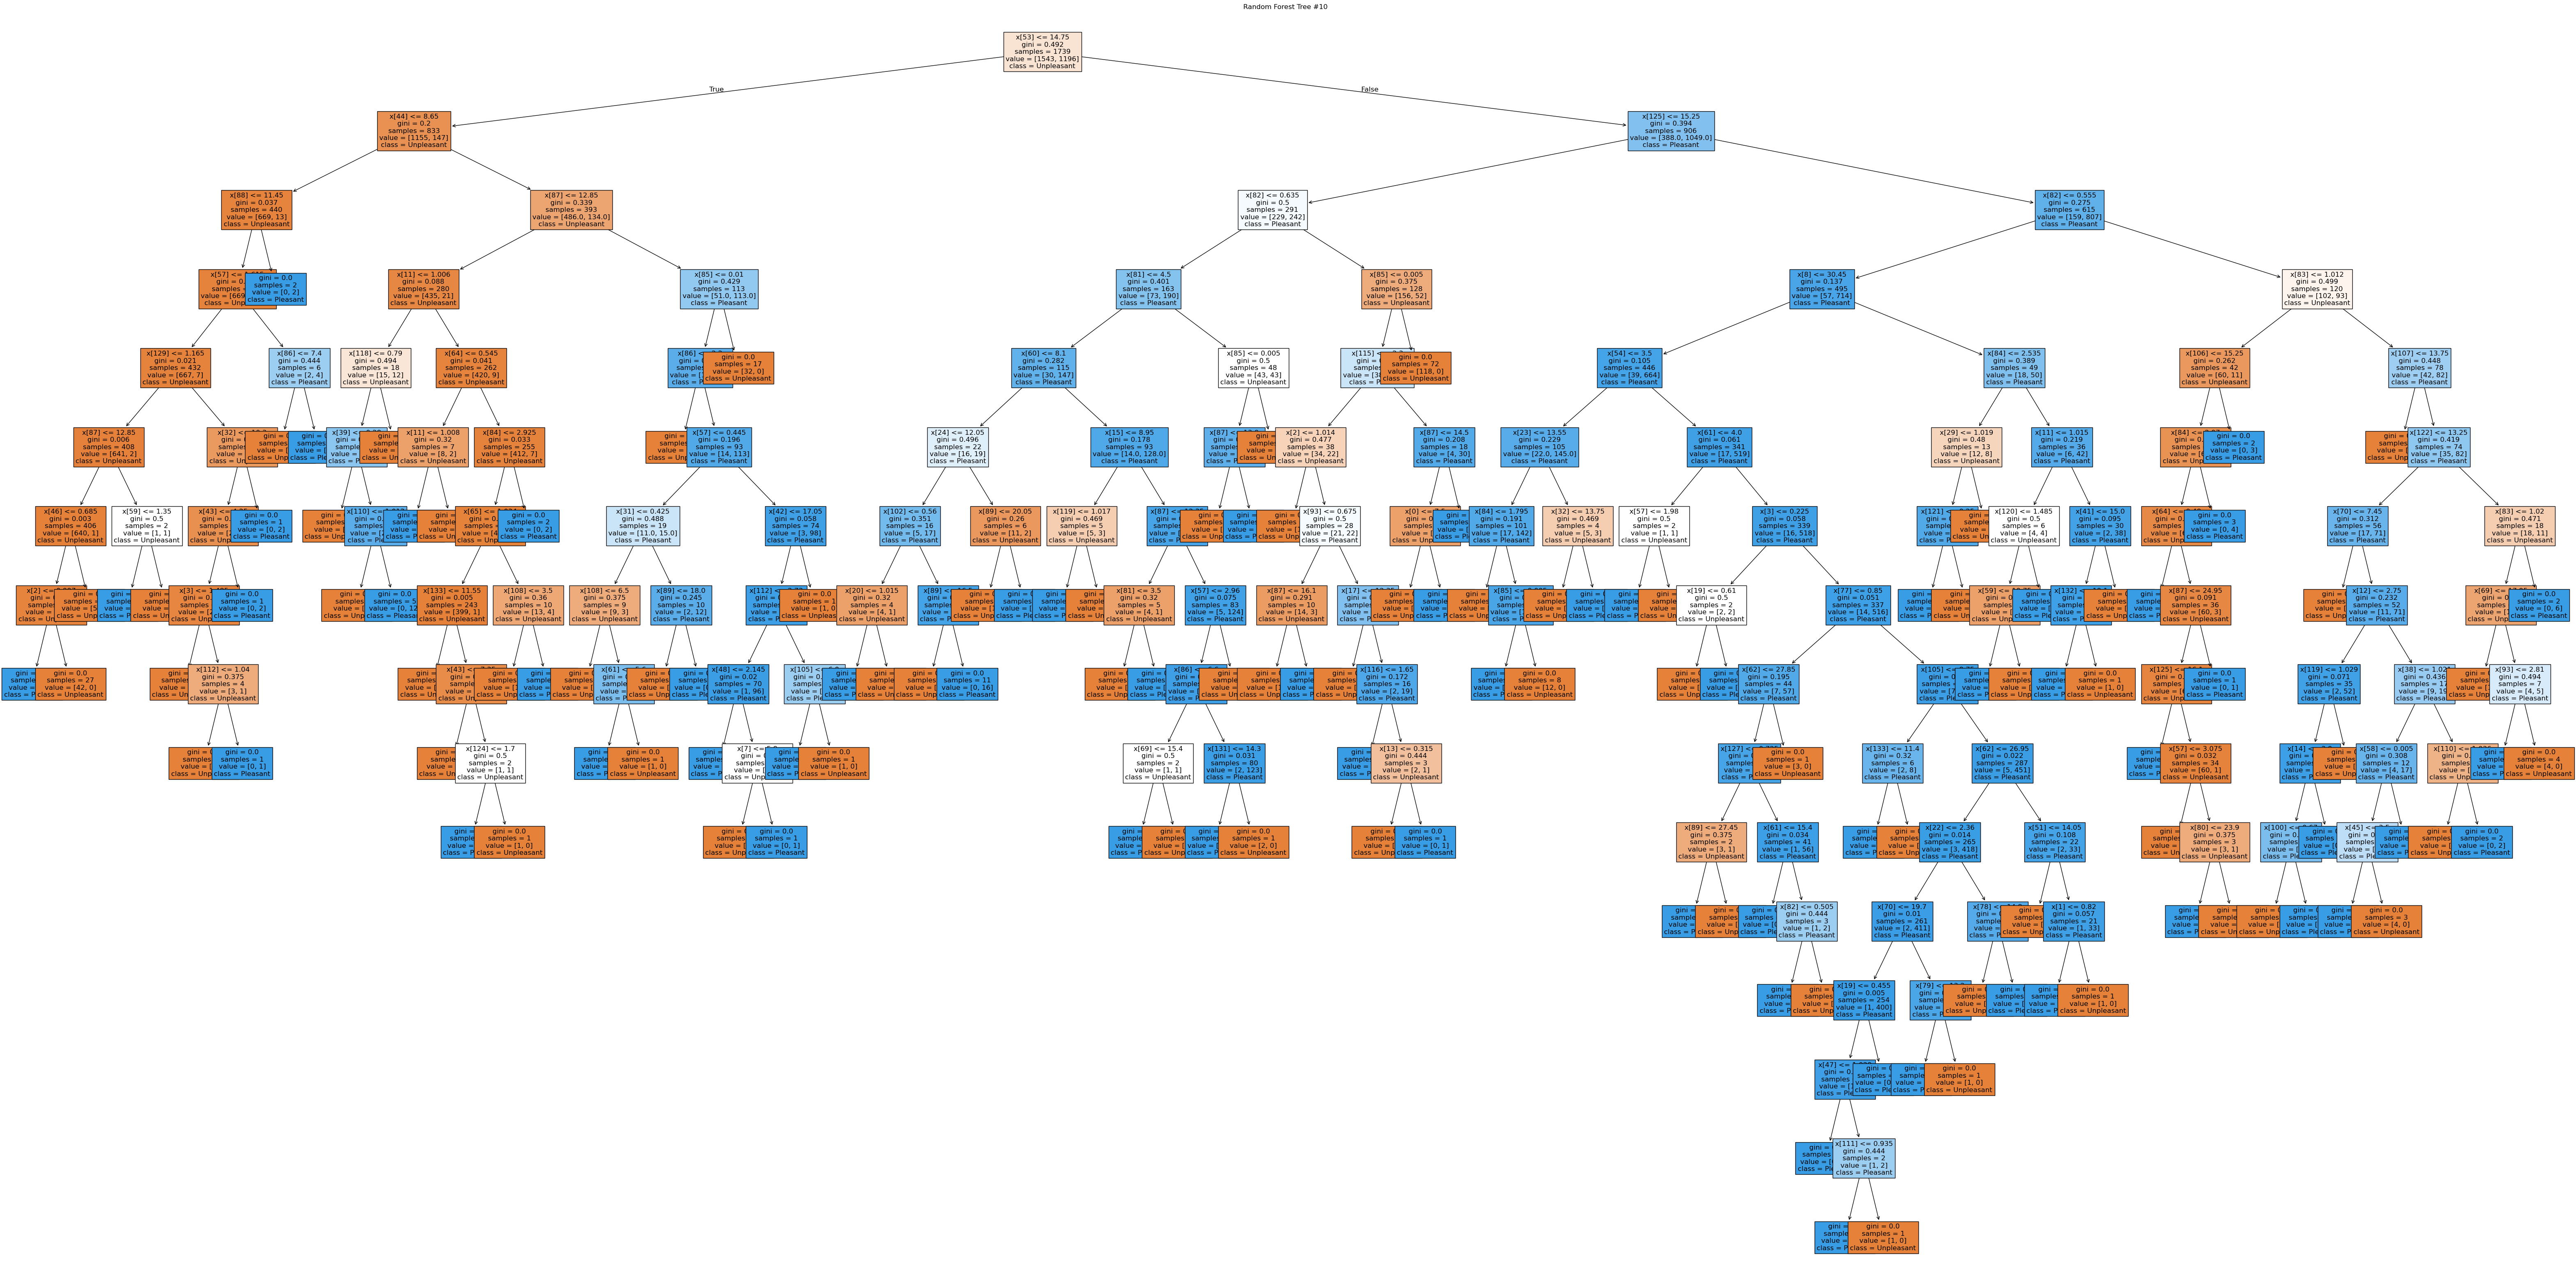

In [88]:
# Plot a decision tree (#10 randomly chosen) from the Random Forest
# optional class_names argument substitutes answer label names for clarity

plt.figure(figsize=(80, 40))
plot_tree(clf.estimators_[10], filled=True, fontsize=12, class_names=['Unpleasant', 'Pleasant'])
plt.title("Random Forest Tree #10")
plt.show()

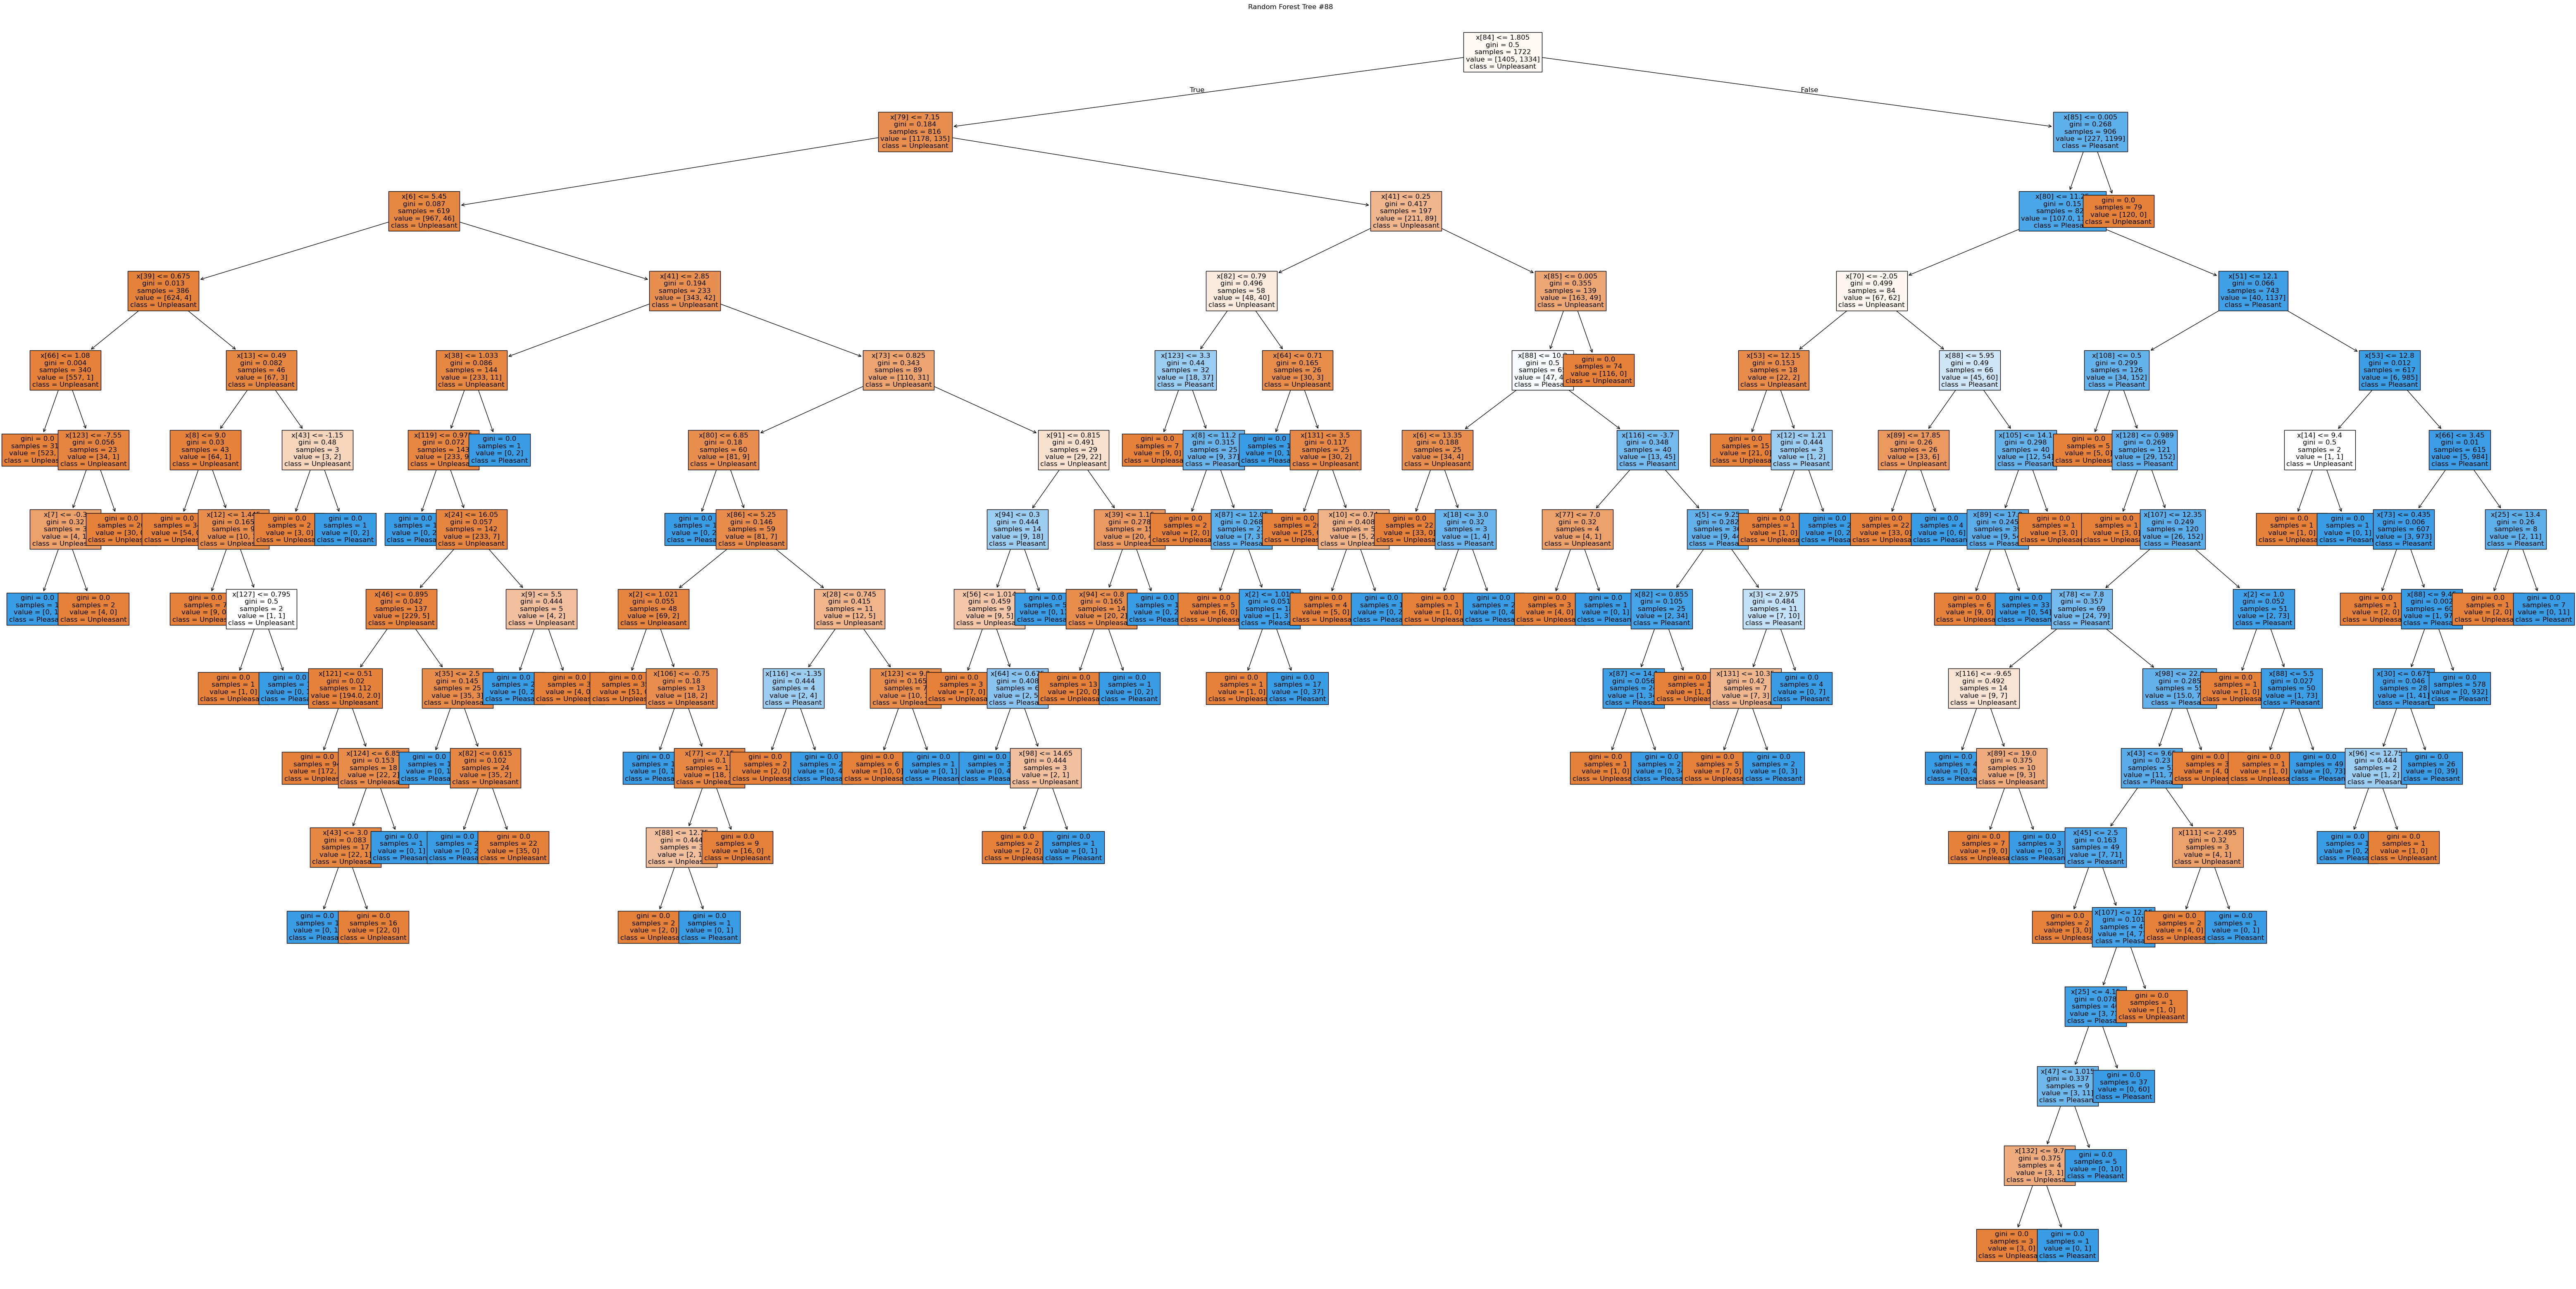

In [90]:
# Plot another decision tree (#88 randomly chosen) from the Random Forest
# optional class_names argument substitutes answer label names for clarity

plt.figure(figsize=(80, 40))
plot_tree(clf.estimators_[88], filled=True, fontsize=12, class_names=['Unpleasant', 'Pleasant'])
plt.title("Random Forest Tree #88")
plt.show()

### 06. Calculate station-feature importances, plot Top 10

In [112]:
# Create list of station-feature names
feature_names = df_unscaled.columns.tolist()

In [118]:
# Check length
len(feature_names)

135

In [122]:
# Check first 11 elements of the list
feature_names[0:10]

['BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BELGRADE_cloud_cover']

In [124]:
# Calculate feature importances from the trained model (clf) using the .feature_importances_ attribute
# Create a pandas Series that maps importances to station-feature names
# Extract the Top 10 data values from the Series

importances = clf.feature_importances_
feature_importance_series = pd.Series(importances, index=feature_names)
top10 = feature_importance_series.sort_values(ascending=False).head(10)

#### Plot Top 10 station-feature importances

In [132]:
plt.figure(figsize=(12, 6))
top10.plot(kind='bar')
plt.title("Top 10 Station-Feature Importances")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 07. Aggregate to station-level importances, plot these

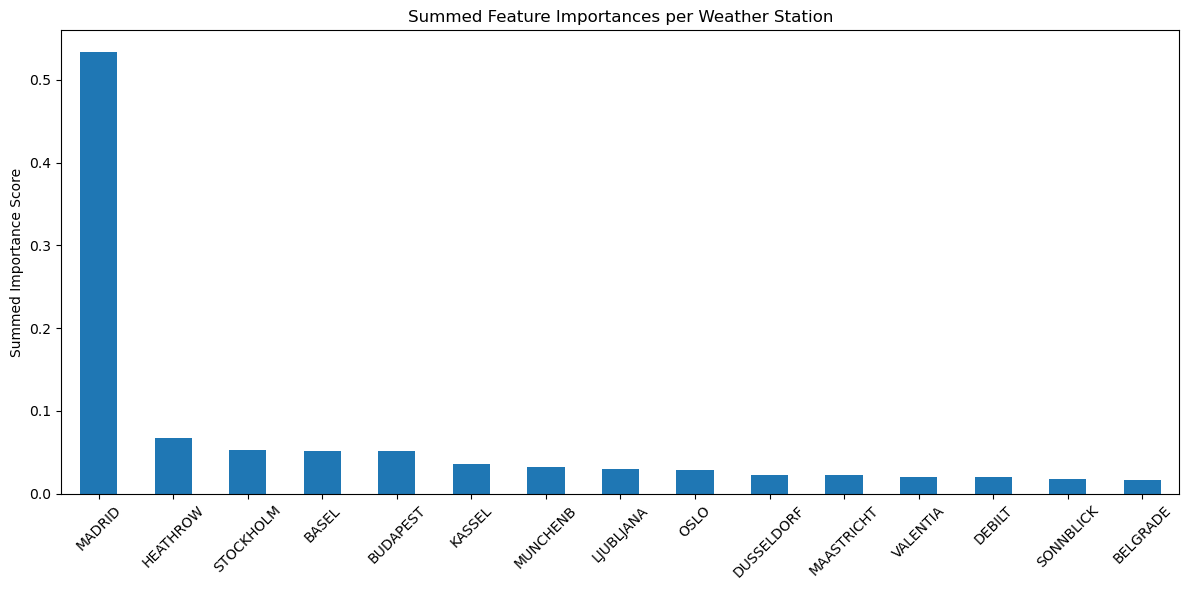

In [139]:
# Extract station names from feature columns
station_names = sorted({col.split('_')[0] for col in feature_names})
station_importance = {station: 0.0 for station in station_names}

# Accumulate importances by station
for feature_name, importance in zip(feature_names, importances):
    station = feature_name.split('_')[0]
    station_importance[station] += importance

# Convert to DataFrame
station_df = pd.Series(station_importance).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
station_df.plot(kind='bar')
plt.title("Summed Feature Importances per Weather Station")
plt.ylabel("Summed Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 08. Interpretation of interim results

#### The first part of Task 2.3 involved: (1) Subsetting temporally the weather data and answers dataframes to a decade of observations (2001-2010); (2) converting (both datasets) and reshaping (answers dataset) data for Random Forests (RF) model use; (3) training the RF model globally on 135 station-features (same-9 weather features for each of 15 weather stations), to predict a single weather station's (Madrid) binary weather outcome answers (as y); (4) where Madrid was chosen as the least imbalanced class (~45/55 Pleasant/Unpleasant weather "Baseline" for that weather station) to mitigate the weaknesses of using an Overall Accuracy scoring metric to assess performance on imbalanced classes; (5) plotting 2 randomly-selected decision trees from the generated RF of 100 trees; (6) calculating and plotting the top 10 station-feature importances; and (7) aggregating these by weather station and plotting same to assess relative station importance impacting prediction of Madrid weather outcomes.

#### Test accuracy of 99.34% for Madrid was very high but not surprising, given that the RF model was trained on all 135 station-features, and our target (y) was only Madrid's binary weather outcome (for a less-imbalanced ~45/55 class profile). Moreover, RF's, when given strong signals (i.e. MADRID_temp_max) and no data leakage, might exceed overall accuracy expectations on "easy" classification tasks.

#### Caveat: This does NOT mean it will generalize well to unseen stations.  The accuracy result simply suggests that Madrid's binary weather outcome can be modeled and predicted well using all the global data (station-features), especially the local data (9 features) of Madrid weather station itself.

#### In a binary classification prediction exercise (as in this Task), the "station-feature" importances from a Random Forests model serve to rank the predictor variables (station-features) based on how effectively they reduce uncertainty when making a prediction.

#### Of the Top 10 station-feature importances, seven (7) were local data-based (Madrid-specific weather features).  THe Top 5 were Madrid-specific, in descending order: max temperature, precipitation, sunshine, global radiation and mean temperature. Global radiation is the total solar energy hitting a unit area (horizontal plane) from direct and diffused sunlight.

#### This suggests local data (features) primarily drive local prediction of Pleasant/Unpleasant weather outcomes.  The top 5 local feature-drivers "make sense" as key predictors of a good or bad weather day.  Interestingly, the cloud_cover variable was not present in the Top 10 feature importances. One tentative explanation is that it might be positively or inversely correlated with other predictor variables that are more powerful, therefore cloud_cover might play a "redundant" role in the predictor hierarchy. Of interest is that Stockholm and Heathrow local temperature-related features made it into the Madrid "Top 10" feature importances, which is counterintuitive and a bit of a mystery.  Stockholm and Heathrow have very different weather from Madrid, thus are those external station-features from distant geographies capturing a Europe-wide weather front moving through (and catching Madrid along the way)?

#### Finally, on the summed importances by weather station, Madrid unsurprisingly dominates (~0.53) summed importances for Madrid itself on the binary classification prediction task.  Externally, Heathrow and Stockholm come next, but far behind at ~0.06-0.07 each.  These stations may correlate well with Madrid's weather patterns (i.e., during heatwaves or particular atmospheric patterns), or might contribute complementary data allowing the RF model to find a larger pattern at work, that enhances model prediction accuracy.

### Next steps

#### The first part of this task taught us only what drives Pleasant weather at a specific station, within a specific decade, based on the RF model trained on all (global) station-features.  The choice of target (y) completely influences or drives the importance rankings.  If Dusseldorf was chosen for y, for example, we would expect DUSSELDORF_temp_max at or near the top of station-feature importances, and Dusseldorf-specific weather variables to populate most of the top importances.

#### The latter part of this task involved running the RF model separately on the 9 (local weather) variables for each station, using the entire 62+ year temporal data range, assessing station-level model accuracy under this altered approach and plotting feature importances to find useful insights.

#### In addition to the task's instruction to run the RF model on the top 3 summed importances stations (which were determined relative to Madrid's y results only), the bottom 3 stations will be added to ensure a fairer assessment of model performance. Also, due to the extreme class imbalance at many stations, other accuracy metrics will be emphasized (balanced accuracy, F1 score (weighted), Recall, Precision).

#### The top 3 summed importances stations (relative to Madrid results) were Madrid, Heathrow and Stockholm.  The bottom 3 were Belgrade, Debilt and Maastricht (excluding Sonnblick which had 100% Unpleasant weather daily data across 62+ years, e.g. not useful to our analysis goals; and Valentia, which had 11.8-12.9 years of bad data at the tail end of the 62+ year temporal range, e.g. an unacceptably high proportion of inaccurate data).  The individual station-level RF model runs and subsequent analysis are presented in separate jupyter notebooks, given the large file sizes generated by RF model work on the weather datasets.